In [1]:
import numpy as np

# packages needed to fetch data
import io
import re
import os
import time
import zipfile
import requests
import random
import pickle
from pprint import pprint
from collections import defaultdict

# machine learning utilities
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer

from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, det_curve
from sklearn.model_selection import train_test_split

# matplotlib and seaborn are famous libraries for graph plotting in Python
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# specifying a static random seed for reproducibility purposes
RANDOM_SEED = 1337

def normalize_cmd(x, custom_domains=["skype.com", "microsoft.com", "azure.com"]):
    x = re.sub(r"(?:[0-9]{1,3}\.){3}[0-9]{1,3}", "example.com", x).replace("localhost","example.com")
    for domain in custom_domains:
        x = x.replace(domain, "example.com")
    return x

In [2]:
open("slp.py", "w").write(requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/slp.py").text)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install bashlex
else:
  code = os.system("python3 -m pip install bashlex nltk")
  if code != 0:
    os.system("python -m pip install bashlex nltk")

In [3]:
datafolder = "../../data/"
data = defaultdict(list)
for file in [x for x in os.listdir(datafolder) if x.endswith("cm")]:
    with open(datafolder+file, encoding="utf-8",  errors='ignore') as f:
        localdata = [x.strip() for x in f.readlines()]

    if "reverse_shell" in file:
        print(f"[!] Took {len(localdata)} malicious commands from:", file)
        data["malicious"] = localdata
    else:
        print(f"[!] Took {len(localdata)} benign commands from:", file)
        data["benign"].extend(localdata)

[!] Took 50855 benign commands from: auditdArgsNormalizedUnique.cm
[!] Took 12607 benign commands from: nl2bash.cm
[!] Took 119154 malicious commands from: reverse_shell_dataset.cm
[!] Took 12662 benign commands from: wazuh_evo_uniq.cm


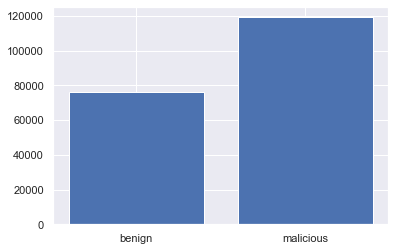

In [4]:
_ = plt.bar(height=[len(data[x]) for x in data.keys()], x=data.keys())
#plt.yscale("log")

In [5]:
total = np.sum([len(data[x]) for x in data.keys()])
print(f"Benign commands form {len(data['benign'])*100/total:.2f}% of total.")
print(f"Total commands in dataset:", total)

Benign commands form 38.98% of total.
Total commands in dataset: 195278


## Preprocessing

In [6]:
# SAMPLE_SIZE = int(1e5)
# data["benign_crop"] = random.sample(data["benign"], SAMPLE_SIZE)
# data["malicious_crop"] = random.sample(data["malicious"], len(data["benign_crop"]))

X = {}
y = np.hstack([np.zeros(len(data["benign"]), dtype=int), np.ones(len(data["malicious"]), dtype=int)])
X["raw"], y = shuffle(data["benign"] + data["malicious"], y, random_state=RANDOM_SEED)
print(len(X["raw"]))
print(y.shape)

195278
(195278,)


In [12]:
# Default
encoder = {}

now = time.time()
key = "CountVectorizerDefault"
encoder[key] = CountVectorizer(lowercase=False,
                    preprocessor=normalize_cmd,
                    ngram_range=(1,2),
                    max_features=1000)
X[key] = encoder[key].fit_transform(X["raw"])
pickle.dump(encoder[key], open(f"../models/{key}_encoder.pickle","wb"))
print(f"[!] {key}: took {time.time() - now:.2f}s")
now = time.time()


key = "HashingVectorizerDefault"
encoder[key] = HashingVectorizer(lowercase=False, 
                       preprocessor=normalize_cmd,
                       ngram_range=(1,2),
                       n_features=2**18)

X[key] = encoder[key].fit_transform(X["raw"])
pickle.dump(encoder[key], open(f"../models/{key}_encoder.pickle","wb"))
print(f"[!] {key}: took {time.time() - now:.2f}s")
now = time.time()

key = "TF-IDFDefault"
encoder[key] = TfidfVectorizer(lowercase=False,
                        preprocessor=normalize_cmd,
                        ngram_range=(1,2),
                        max_features=1000)
X[key] = encoder[key].fit_transform(X["raw"])
pickle.dump(encoder[key], open(f"../models/{key}_encoder.pickle","wb"))
print(f"[!] {key}: took {time.time() - now:.2f}s")

# NLTK
from nltk.tokenize import WordPunctTokenizer
wpt = WordPunctTokenizer()

now = time.time()
key = "CountVectorizerWPT"
encoder[key] = CountVectorizer(lowercase=False,
    preprocessor=normalize_cmd,
    ngram_range=(1,2),
    tokenizer=wpt.tokenize,
    token_pattern=None,
    max_features=1000)
X[key] = encoder[key].fit_transform(X["raw"])
pickle.dump(encoder[key], open(f"../models/{key}_encoder.pickle","wb"))
print(f"[!] {key}: took {time.time() - now:.2f}s")
now = time.time()


key = "HashingVectorizerWPT"
encoder[key] = HashingVectorizer(
    lowercase=False,
    preprocessor=normalize_cmd,
    ngram_range=(1,2),
    tokenizer=wpt.tokenize,
    token_pattern=None,
    n_features=2**18)
X[key] = encoder[key].fit_transform(X["raw"])
pickle.dump(encoder[key], open(f"../models/{key}_encoder.pickle","wb"))
print(f"[!] {key}: took {time.time() - now:.2f}s")
now = time.time()

key = "TF-IDFWPT"
encoder[key] = TfidfVectorizer(
    lowercase=False,
    preprocessor=normalize_cmd,
    ngram_range=(1,2),
    tokenizer=wpt.tokenize,
    token_pattern=None,
    max_features=1000)
X[key] = encoder[key].fit_transform(X["raw"])
pickle.dump(encoder[key], open(f"../models/{key}_encoder.pickle","wb"))
print(f"[!] WordPunctTokenizer TF-IDF tokenizer: took {time.time() - now:.2f}s")


[!] CountVectorizerDefault: took 10.63s
[!] HashingVectorizerDefault: took 6.44s
[!] TF-IDFDefault: took 10.50s
[!] CountVectorizerWPT: took 16.84s
[!] WordPunctTokenizer HV tokenizer: took 11.48s
[!] WordPunctTokenizer TF-IDF tokenizer: took 16.48s


### Note on slp.ShellTokenizer 

Takes too long -- HV ~90s, TF-IDF ~300s for 20k samples, where sklearns default tokenizer less than 1s...  
Code used:
```
from slp import ShellTokenizer
shell_tokenizer = ShellTokenizer(verbose=True, debug=False)
hvslp = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
tfidfslp = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
now = time.time()
X["HashingVectorizerSLP"] = hvslp.fit_transform(X["raw"])
print(f"[!] SLP HV tokenizer: took {time.time() - now:.2f}s")
now = time.time()
X["TF-IDF-SLP"] = tfidfslp.fit_transform(X["raw"])
print(f"[!] SLP TF-IDF tokenizer: took {time.time() - now:.2f}s")

```

## Testing with Cross-Validation

In [10]:
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

def print_scores(cv):
    means = np.mean(list(cv.values()), axis=1)
    [print(f"\tAverage {x[0].strip('test_'):<10} over all folds: {x[1]:.2f}") for x in zip(cv.keys(), means) if "test_" in x[0]]
    print()

models = {}
for key in (X.keys() - ["raw"]):
    tick = time.time()
    print(f"{key}:")
    models[key] = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_SEED)
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    cv = cross_validate(models[key], X[key], y, cv=skf, scoring=metrics)
    
    print_scores(cv)
    print(f"Took: {time.time()-tick:.2f}s")

TF-IDF-Default:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 1.00
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

Took: 23.17s
CountVectorizerWPT:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 1.00
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

Took: 12.13s
HashingVectorizerWPT:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 1.00
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

Took: 25.89s
TF-IDF-WPT:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 1.00
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

Took: 19.39s
CountVectorizerDefault:
	Average accuracy   over all f

## Testing with Train-Test split

TF-IDF-Default in process...
CountVectorizerWPT in process...
HashingVectorizerWPT in process...
TF-IDF-WPT in process...
CountVectorizerDefault in process...
HashingVectorizerDefault in process...


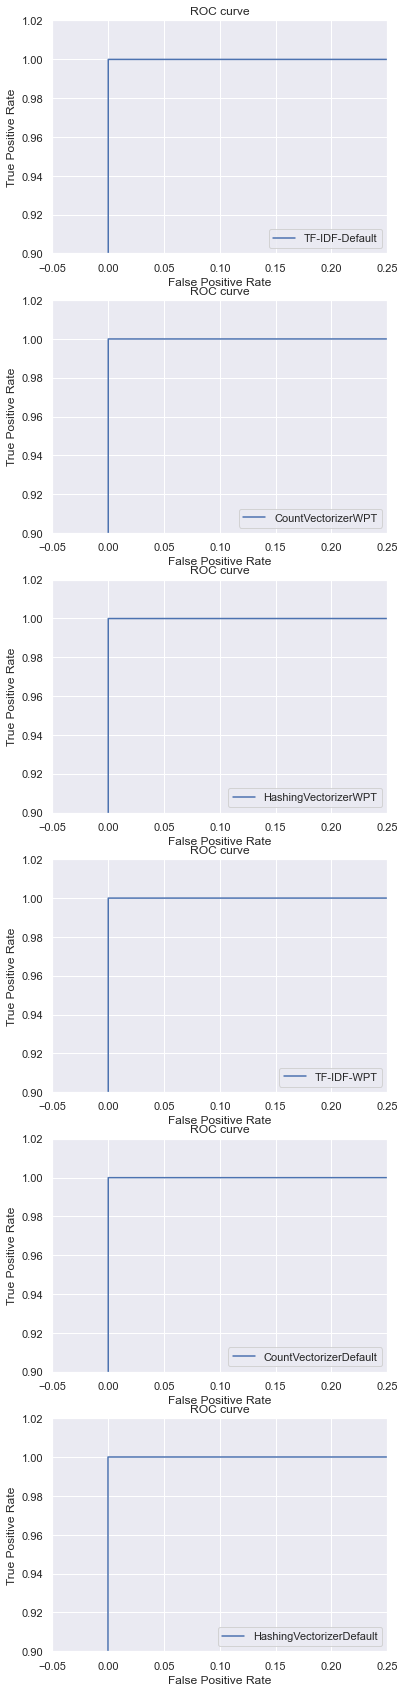

In [13]:
def plot_roc_metrics(preds, y_true, metrics, name, ax=None):
    metrics["fpr"][name], metrics["tpr"][name], metrics["threshold_roc"][name] = roc_curve(y_true, preds)
    _, metrics["fnr"][name], metrics["threshold_det"][name] = det_curve(y_true, preds)
    if ax:
        ax.plot(metrics["fpr"][name], metrics["tpr"][name], linestyle="solid", label=name)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_ylim([0.9,1.02])
        ax.set_xlim([-0.05,0.25])
        ax.set_title("ROC curve", fontsize=12)
        ax.legend(loc="lower right")
    return metrics

plots = len(X.keys() - ["raw"])
f, ax = plt.subplots(plots, 1, figsize=(plots,plots*5))
i = 0
metrics = defaultdict(dict)
for key in (X.keys() - ["raw"]):
    print(key, "in process...")
    X_train, X_test, y_train, y_test = train_test_split(X[key], y, test_size=0.2, random_state=RANDOM_SEED)
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_SEED)
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict_proba(X_test)[:,1]
    metrics = plot_roc_metrics(preds, y_test, metrics, name = key, ax=ax[i])
    i += 1 

Too perfect ....


## Dumping fully trained model

In [13]:
for key in (X.keys() - ["raw"]):
    print(key, "in process...")
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    xgb_model.fit(X[key], y)
    xgb_model.save_model(f"../models/{key}.model")

TF-IDFDefault in process...
CountVectorizerDefault in process...
HashingVectorizerDefault in process...
HashingVectorizerWPT in process...
CountVectorizerWPT in process...
TF-IDFWPT in process...
